In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.0
0.11.1


In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")

C:\Users\kajte\anaconda3\envs\py39_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data

In [6]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    image_path.mkdir(parent=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data...")
        f.wirte(request.content)

    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [33]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models

model = models.efficientnet_b0(pretrained=True)

transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),  # Resize with bicubic interpolation
    transforms.CenterCrop(224),      # Crop the center 224x224 portion of the image
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize(            # Normalize the image's pixel values
        mean=[0.485, 0.456, 0.406],   # using ImageNet's mean and standard deviation
        std=[0.229, 0.224, 0.225]
    )
])

In [35]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2d8d9970e50>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

In [36]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# NEW: Setup the mdoel with pretrained weights and sent it to the target device (torchvision v0.13+)
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(weights=weights)

In [40]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        # col_names=["input_size] for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]  # what features to show in row
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [41]:
# Freeze all base layers in the "features" section of the model (feature extractor)
for param in model.features.parameters():
    param.requires_grad = False  # Feature extractor layers frozen

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

# Recreate the classfier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [54]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [58]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=criterion,
                       epochs=5,
                       device=device)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:10<00:42, 10.68s/it]

Epoch: 1 | train_loss: 1.0922 | train_acc: 0.3906 | test_loss: 0.9112 | test_acc: 0.5502


 40%|████      | 2/5 [00:20<00:30, 10.31s/it]

Epoch: 2 | train_loss: 0.8745 | train_acc: 0.7578 | test_loss: 0.7923 | test_acc: 0.8456


 60%|██████    | 3/5 [00:31<00:20, 10.34s/it]

Epoch: 3 | train_loss: 0.7669 | train_acc: 0.8008 | test_loss: 0.7451 | test_acc: 0.8456


 80%|████████  | 4/5 [00:41<00:10, 10.44s/it]

Epoch: 4 | train_loss: 0.7223 | train_acc: 0.7422 | test_loss: 0.6368 | test_acc: 0.8551


100%|██████████| 5/5 [00:54<00:00, 11.00s/it]

Epoch: 5 | train_loss: 0.6277 | train_acc: 0.7734 | test_loss: 0.6286 | test_acc: 0.8968
[INFO] Total training time: 54.997 seconds


## 5. Evaluate model by plotting loss curves

In [65]:
from typing import Tuple, Dict, List

In [66]:
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    # Get the accuracy values of the results dictionary
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    
    # Setup a plot
    plt.figure(figsize=(15, 7))
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

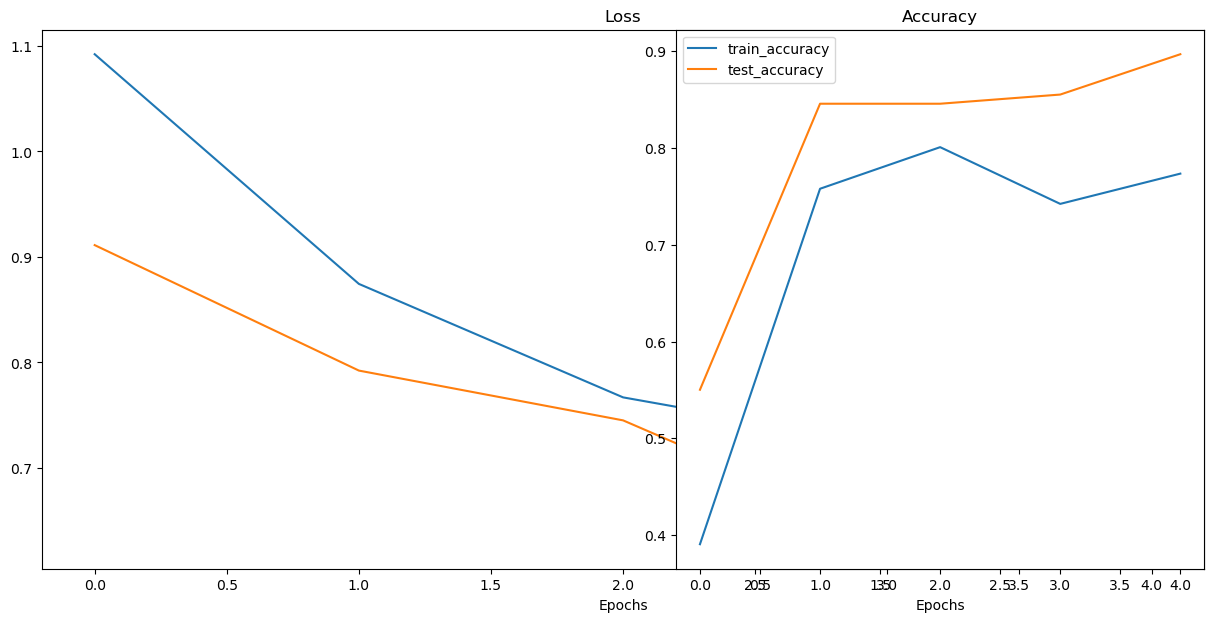

In [67]:
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [80]:
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device=device):

    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    model.to(device)

    model.eval()  # Turn on mdodel evaluation mode and inference mode
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

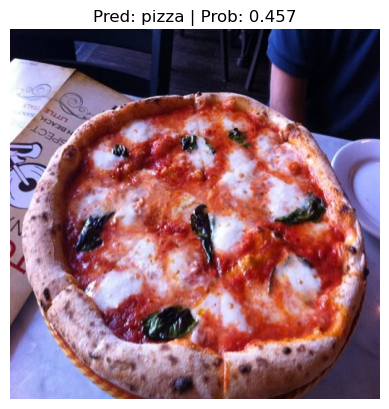

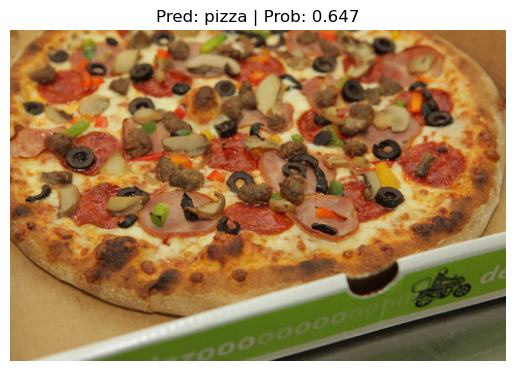

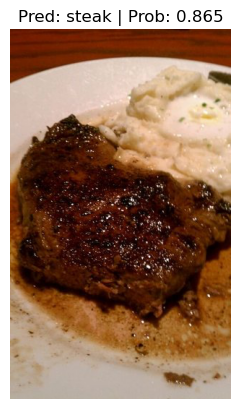

In [82]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))  # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

In [93]:
import requests

custom_image_path = data_path / "pizza+man.jpg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://3.bp.blogspot.com/-9EZ0JuaIXTc/ULz46KAmdDI/AAAAAAAAAKQ/UTLL7HyxYzc/s1600/pizza+man.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

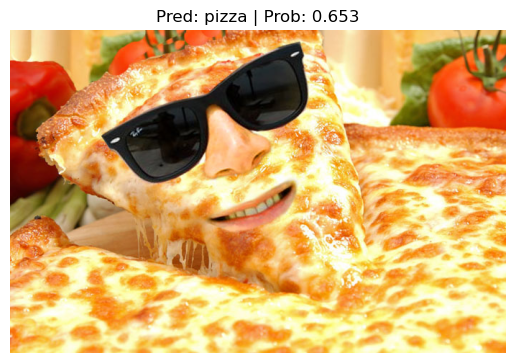

In [94]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)